In [18]:
import re
import string
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
import torch
import seaborn as sns
from torch.nn import CrossEntropyLoss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [19]:
seed = 123

In [21]:
df = pd.read_csv('comments with acceptreject.csv')
data = df.iloc[:,1:3]
dataset = Dataset.from_pandas(data)

In [22]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

d:\anaconda3\envs\bert\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data['text_comments'], data['label'], train_size = 0.7, random_state=seed)

In [ ]:
train_tokens = tokenizer(list(train_X), padding = True, truncation=True)
test_tokens = tokenizer(list(test_X), padding = True, truncation=True)

In [5]:
def preprocess_function(examples):
    return tokenizer(examples['text_comments'], truncation=True, padding=True, max_length=50)

In [ ]:
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = train_X
            self.tokens = train_tokens
            self.labels = list(train_Y)
        else:
            self.text_data = test_X
            self.tokens = test_tokens
            self.labels = list(test_Y)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

In [ ]:
batch_size = 40
train_dataset = TokenData(train = True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TokenData(train = False)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [6]:
train_val_split = dataset.train_test_split(test_size=0.2, seed=seed)

# Split the remaining 80% into 60% train and 20% validation (which is 75%:25% of the remaining 80%)
train_split = train_val_split['train'].train_test_split(test_size=0.25, seed=seed)

# Assign splits
train_dataset = train_split['train']
val_dataset = train_split['test']
test_dataset = train_val_split['test']
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x0000026D45937D30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 1/1 [00:00<00:00, 68.93ba/s]


In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Get predicted class

    # Calculate precision, recall, F1, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted", zero_division=0)
    acc = accuracy_score(labels, predictions)

    # Return metrics
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1  
    }

In [8]:
train_labels = train_dataset['label']
classes = np.array([0, 1])

In [9]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights  # Store the class weights

    def compute_loss(self, model, inputs, return_outputs=False):
        # Forward pass through the model
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Get the number of labels from model config
        num_labels = model.config.num_labels
        
        # Apply the loss function with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [10]:
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)  # Adjust classes if needed
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",     # Evaluate at the end of every epoch
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,  # Batch size for evaluation
    num_train_epochs=10,
    weight_decay=0.001,
    logging_dir="./logs",
    logging_steps=50,               # Log every 50 steps
    save_strategy="epoch",          # Save checkpoints at the end of each epoch
    load_best_model_at_end=True,    # Automatically load the best model based on validation
    metric_for_best_model="loss", # Metric to determine the best model
    greater_is_better=False,         # Specify if higher metric is better
    seed=seed,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Your training dataset
    eval_dataset=val_dataset,    # Your validation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
#trainer = CustomTrainer(
#    model=model,
#    args=training_args,
    #train_dataset=train_dataset,
    #eval_dataset=val_dataset,
    #tokenizer=tokenizer,
    #class_weights=class_weights_tensor,
    #compute_metrics=compute_metrics  # Assuming compute_metrics is defined
#)


In [12]:
trainer.train()

                                               
 10%|█         | 10/100 [00:01<00:10,  8.39it/s]

{'eval_loss': 0.6714817881584167, 'eval_accuracy': 0.62, 'eval_precision': 0.38439999999999996, 'eval_recall': 0.62, 'eval_f1': 0.4745679012345678, 'eval_runtime': 0.2576, 'eval_samples_per_second': 194.097, 'eval_steps_per_second': 15.528, 'epoch': 1.0}


                                                
 20%|██        | 20/100 [00:06<00:13,  6.03it/s]

{'eval_loss': 0.7414336204528809, 'eval_accuracy': 0.64, 'eval_precision': 0.6206060606060606, 'eval_recall': 0.64, 'eval_f1': 0.6125714285714285, 'eval_runtime': 0.1131, 'eval_samples_per_second': 442.105, 'eval_steps_per_second': 35.368, 'epoch': 2.0}


                                                
 30%|███       | 30/100 [00:23<00:26,  2.60it/s]

{'eval_loss': 1.1258444786071777, 'eval_accuracy': 0.62, 'eval_precision': 0.5978947368421053, 'eval_recall': 0.62, 'eval_f1': 0.596372136512389, 'eval_runtime': 0.114, 'eval_samples_per_second': 438.599, 'eval_steps_per_second': 35.088, 'epoch': 3.0}


                                                
 40%|████      | 40/100 [00:38<00:20,  2.90it/s]

{'eval_loss': 2.5446910858154297, 'eval_accuracy': 0.5, 'eval_precision': 0.5049999999999999, 'eval_recall': 0.5, 'eval_f1': 0.5023118957545187, 'eval_runtime': 0.1141, 'eval_samples_per_second': 438.152, 'eval_steps_per_second': 35.052, 'epoch': 4.0}


 50%|█████     | 50/100 [00:53<00:17,  2.78it/s]

{'loss': 0.2967, 'grad_norm': 0.01523417979478836, 'learning_rate': 5e-05, 'epoch': 5.0}


                                                
 50%|█████     | 50/100 [00:53<00:17,  2.78it/s]

{'eval_loss': 2.8086864948272705, 'eval_accuracy': 0.6, 'eval_precision': 0.5775467775467775, 'eval_recall': 0.6, 'eval_f1': 0.5801470588235295, 'eval_runtime': 0.0909, 'eval_samples_per_second': 550.042, 'eval_steps_per_second': 44.003, 'epoch': 5.0}


                                                
 60%|██████    | 60/100 [01:03<00:11,  3.61it/s]

{'eval_loss': 2.9075984954833984, 'eval_accuracy': 0.56, 'eval_precision': 0.5785507246376811, 'eval_recall': 0.56, 'eval_f1': 0.5657799671592776, 'eval_runtime': 0.1212, 'eval_samples_per_second': 412.401, 'eval_steps_per_second': 32.992, 'epoch': 6.0}


                                                
 70%|███████   | 70/100 [01:23<00:13,  2.27it/s]

{'eval_loss': 2.923748254776001, 'eval_accuracy': 0.58, 'eval_precision': 0.6273376623376623, 'eval_recall': 0.58, 'eval_f1': 0.5845523885989562, 'eval_runtime': 0.1187, 'eval_samples_per_second': 421.165, 'eval_steps_per_second': 33.693, 'epoch': 7.0}


                                                
 80%|████████  | 80/100 [01:39<00:07,  2.60it/s]

{'eval_loss': 2.7917280197143555, 'eval_accuracy': 0.6, 'eval_precision': 0.6085385878489327, 'eval_recall': 0.6, 'eval_f1': 0.6033333333333333, 'eval_runtime': 0.1203, 'eval_samples_per_second': 415.731, 'eval_steps_per_second': 33.258, 'epoch': 8.0}


                                                
 90%|█████████ | 90/100 [01:52<00:03,  3.17it/s]

{'eval_loss': 2.916745662689209, 'eval_accuracy': 0.6, 'eval_precision': 0.5847619047619047, 'eval_recall': 0.6, 'eval_f1': 0.5885918003565063, 'eval_runtime': 0.1183, 'eval_samples_per_second': 422.688, 'eval_steps_per_second': 33.815, 'epoch': 9.0}


100%|██████████| 100/100 [02:06<00:00,  2.87it/s]

{'loss': 0.0076, 'grad_norm': 0.0046182237565517426, 'learning_rate': 0.0, 'epoch': 10.0}


                                                 
100%|██████████| 100/100 [02:19<00:00,  2.87it/s]

{'eval_loss': 2.960968017578125, 'eval_accuracy': 0.6, 'eval_precision': 0.5847619047619047, 'eval_recall': 0.6, 'eval_f1': 0.5885918003565063, 'eval_runtime': 0.393, 'eval_samples_per_second': 127.221, 'eval_steps_per_second': 10.178, 'epoch': 10.0}


100%|██████████| 100/100 [02:33<00:00,  1.53s/it]

{'train_runtime': 153.1507, 'train_samples_per_second': 9.794, 'train_steps_per_second': 0.653, 'train_loss': 0.1521659728884697, 'epoch': 10.0}


TrainOutput(global_step=100, training_loss=0.1521659728884697, metrics={'train_runtime': 153.1507, 'train_samples_per_second': 9.794, 'train_steps_per_second': 0.653, 'total_flos': 38541658500000.0, 'train_loss': 0.1521659728884697, 'epoch': 10.0})

In [13]:
metrics = trainer.evaluate(eval_dataset=test_dataset)
predictions_output = trainer.predict(test_dataset)

100%|██████████| 4/4 [00:00<00:00, 60.43it/s]


In [14]:
print(metrics)

{'eval_loss': 0.720197856426239, 'eval_accuracy': 0.56, 'eval_precision': 0.31360000000000005, 'eval_recall': 0.56, 'eval_f1': 0.40205128205128204, 'eval_runtime': 0.2801, 'eval_samples_per_second': 178.498, 'eval_steps_per_second': 14.28, 'epoch': 10.0}


In [15]:
logits = predictions_output.predictions  # shape (num_samples, num_classes)
labels = predictions_output.label_ids    # shape (num_samples,)

# Convert logits to predicted class labels (argmax)
predicted_labels = np.argmax(logits, axis=-1)


# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)


In [16]:


# Print confusion matrix to check
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(labels, predicted_labels))

d:\anaconda3\envs\bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[28  0]
 [22  0]]
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        28
           1       0.00      0.00      0.00        22

    accuracy                           0.56        50
   macro avg       0.28      0.50      0.36        50
weighted avg       0.31      0.56      0.40        50



d:\anaconda3\envs\bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


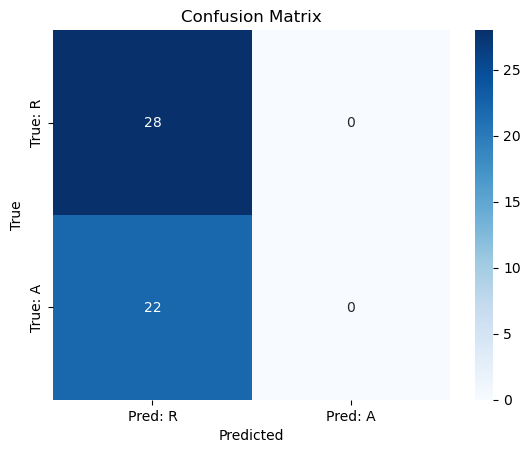

In [17]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred: R', 'Pred: A'], 
                yticklabels=['True: R', 'True: A'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()